In [1]:
import midynet
import midynet.util.display as display
import numpy as np
import matplotlib.pyplot as plt
import pathlib

display.setup_dir("./")

## Loading the experiments

In [2]:
dynamics = "cowan"
path_to_data = {
    "exact": pathlib.Path(f"/home/charles_murphy/Documents/ulaval/doctorat/projects/data/midynet-data/figure2/exact-{dynamics}/"),
    "small-mf": pathlib.Path(f"/home/charles_murphy/Documents/ulaval/doctorat/projects/data/midynet-data/figure3/small/figure3-small-{dynamics}.meanfield/"),
    "small-ais": pathlib.Path(f"/home/charles_murphy/Documents/ulaval/doctorat/projects/data/midynet-data/figure3/small/figure3-small-{dynamics}.annealed/"),
    "large-mf": pathlib.Path(f"/home/charles_murphy/Documents/ulaval/doctorat/projects/data/midynet-data/figure3/large/figure3-large-{dynamics}.meanfield/"),
    "large-ais": pathlib.Path(f"/home/charles_murphy/Documents/ulaval/doctorat/projects/data/midynet-data/figure3/large/figure3-large-{dynamics}.annealed/"),
}
exp = {k: midynet.experiments.Experiment.load_from_file(p / "config.pickle") for k, p in path_to_data.items()}

# exp = midynet.experiments.Experiment.load_from_file(path_to_data / "config.pickle")

if dynamics == "sis":
    xlabel = r"Infection probability $[\alpha]$"
elif dynamics == "cowan":
    xlabel = r"Activity gain $[\nu\langle k \rangle]$"
elif dynamics == "ising":
    xlabel = r"Coupling $[J\langle k \rangle]$"

N = exp["exact"].config.graph.size
E = exp["exact"].config.graph.edge_count.state
T = exp["exact"].config.dynamics.num_steps


if dynamics == "sis":
    x_exact = exp["exact"].config.dynamics.infection_prob
    x_mcmc = exp["small-mf"].config.dynamics.infection_prob
    xmin, xmax = 0, 1
elif dynamics == "cowan":
    x_exact = exp["exact"].config.dynamics.nu
    x_mcmc = exp["small-mf"].config.dynamics.nu
    xmin, xmax = 0, 4
elif dynamics == "ising":
    x_exact = exp["exact"].config.dynamics.coupling
    x_mcmc = exp["small-mf"].config.dynamics.coupling
    xmin, xmax = 0, 4
ymin, ymax = 0, 1.1


## Figure 3

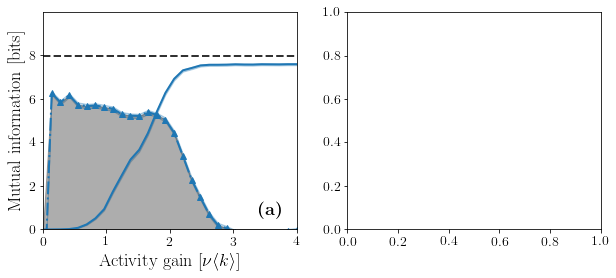

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
t_index = np.where(np.array(T) == 100)[0][0]
ec_index = np.where(np.array(E) == 5)[0][0]
ec = E[ec_index]
t = T[t_index]
color_exact = display.med_colors["blue"]
color_mf = display.med_colors["blue"]
color_ais = display.med_colors["blue"]

bit_ratio = np.log(2)
hg = {key: midynet.metrics.Statistics({k: _exp.metrics["mutualinfo"].data[_exp.name][f"hg-{k}"] for k in ["mid", "high", "low"]}) / bit_ratio for key, _exp in exp.items()}
hgx = {key: midynet.metrics.Statistics({k: _exp.metrics["mutualinfo"].data[_exp.name][f"hgx-{k}"] for k in ["mid", "high", "low"]}) / bit_ratio for key, _exp in exp.items()}
hg["exact"] = midynet.metrics.Statistics(hg["exact"][t_index, :, ec_index])
hgx["exact"] = midynet.metrics.Statistics(hgx["exact"][t_index, :, ec_index])
mi = {key: hg[key] - hgx[key] for key in exp.keys()}

midynet.metrics.Statistics.plot(
    ax[0], x_exact, mi["exact"], 
    fill_alpha=0.3, 
    color=color_exact,
    linestyle="-",
    linewidth=2,
    marker="None",
)

midynet.metrics.Statistics.plot(
    ax[0], x_mcmc, mi["small-mf"], 
    fill_alpha=0.3, 
    color=color_mf,
    linestyle="-.",
    linewidth=2,
    marker="^",
)

midynet.metrics.Statistics.plot(
    ax[0], x_mcmc, mi["small-ais"], 
    fill_alpha=0.3, 
    color=color_ais,
    linestyle="dotted",
    linewidth=2,
    marker="o",
)

y1 = np.clip(mi["small-mf"]["mid"], 0, hg["small-mf"]["mid"])
y2 = np.clip(mi["small-ais"]["mid"], 0, hg["small-ais"]["mid"])
ax[0].fill_between(x_mcmc, y1, y2, color=display.dark_colors["grey"], alpha=0.4)
ax[0].set_xlim([xmin, xmax])
ax[0].set_ylim([0, ax[0].get_ylim()[1]])
ax[0].set_xlabel(xlabel, fontsize=18)
ax[0].set_ylabel(r"Mutual information [bits]", fontsize=18)
ax[0].tick_params(axis='both', labelsize=14)
ax[0].plot(x_exact, hg["exact"]["mid"], linestyle="--", marker="None", color=display.dark_colors["grey"], linewidth=2)
display.label_plot(ax[0], r"\textbf{(a)}", loc="lower right", fontsize=18)



# x_mf = exp["large-meanfield"].config.dynamics.j
# y_mf = exp["large-meanfield"].metrics["MutualInformationMetrics"].data
# get_plot(
#     exp["large-meanfield"].config.dynamics.j, 
#     y_mf, 
#     ax=ax[1], 
#     norm=1/(np.log2(np.exp(1))),
#     fill_alpha=0.3,
#     color="k",
#     markerfacecolor=color_mf, 
#     linestyle="-.", 
#     linewidth=2,
#     marker="^",
# )

# x_ais = exp["large-annealed"].config.dynamics.j
# y_ais = exp["large-annealed"].metrics["MutualInformationMetrics"].data
# get_plot(
#     x_ais, 
#     y_ais, 
#     ax=ax[1], 
#     norm=1/(np.log2(np.exp(1))),
#     fill_alpha=0.3,
#     linewidth=2,
#     color="k",
#     markerfacecolor=color_ais, 
#     linestyle="dotted", 
#     marker="o",
# )

# x = np.linspace(0, 4, 100)
# f1, f2 = interp1d(x_mf, y_mf["mid"]), interp1d(x_ais, y_ais["mid"])

# y1 = np.clip(f1(x), 0, exp["large-meanfield"].metrics["GraphEntropyMetrics"].data["mid"][0]) * np.log2(np.exp(1))
# y2 = np.clip(f2(x), 0, exp["large-annealed"].metrics["GraphEntropyMetrics"].data["mid"][0]) * np.log2(np.exp(1))
# ax[1].fill_between(x, y1, y2, color=display.dark_colors["grey"], alpha=0.5)
# ax[1].set_xlim([xmin, 4])
# ax[1].set_ylim([0, ax[1].get_ylim()[1]])
# ax[1].set_xlabel(r"Coupling $\left[J\langle k \rangle\right]$", fontsize=18)
# ax[1].set_ylabel(r"Mutual information [bits]", fontsize=18)
# ax[1].tick_params(axis='both', labelsize=14)
# ax[1].plot(
#     exp["large-meanfield"].config.dynamics.j,
#     exp["large-annealed"].metrics["GraphEntropyMetrics"].data["mid"] * np.log2(np.exp(1)),
#     linestyle="--",
#     marker="None",
#     color=display.dark_colors["grey"],
#     linewidth=2
# )
# display.label_plot(ax[1], r"\textbf{(b)}", loc="lower right", fontsize=18)

# handles = [
#     mpl.lines.Line2D([0], [0], color=color_exact, linestyle="-", marker="None", linewidth=2, label=r"Exact"),
#     mpl.lines.Line2D([0], [0], color="k", markerfacecolor=color_mf, linestyle="-.", marker="^", linewidth=2, label=r"MF"),
#     mpl.lines.Line2D([0], [0], color="k", markerfacecolor=color_ais, linestyle="dotted", marker="o", linewidth=2, label=r"AIS"),
#     mpl.lines.Line2D([0], [0], color=display.dark_colors["grey"], alpha=0.4, linestyle="None", marker="s", markersize=12, label=r"Admissible"),
# ]
# ax[1].legend(handles=handles, fontsize=14, loc="upper right")

# fig.tight_layout()

# fig.savefig(path_to_figures + "/svg/p1-figure3.svg")
# fig.savefig(path_to_figures + "/png/p1-figure3.png")
# fig.savefig(path_to_figures + "/pdf/p1-figure3.pdf")

In [7]:
hgx

{'exact': Statistics(mid=[7.97727992 7.97565066 7.97072849 7.95746549 7.90242234 7.74422832
  7.46572598 7.0437985  6.23668818 5.50112788 4.77699919 4.32823917
  3.56064058 2.59358644 1.71256418 1.06763491 0.6777135  0.56948165
  0.45225823 0.42209792 0.42157565 0.41586286 0.40012117 0.40953455
  0.41148303 0.39640357 0.3998938  0.40305235 0.39456218 0.39453268]),
 'small-mf': Statistics(mid=[12.64943898  1.71957594  2.14351893  1.81308711  2.25175945  2.31692651
   2.28590208  2.35832868  2.43717592  2.68346805  2.75332948  2.76702337
   2.58887477  2.71596551  2.93614256  3.53705472  4.60491729  5.69090023
   6.50497224  7.27696666  7.7715188   7.92054201  8.10913416  8.1823498
   8.20227706  8.22518843  8.20193941  8.20694751  8.05914297  8.02020345]),
 'small-ais': Statistics(mid=[13.66909536 13.70461697 13.78658636 13.90135557 14.30254691 14.94445807
  15.88235393 17.37583775 19.38509865 21.3148699  23.9293828  26.64409715
  31.51916615 37.09237515 42.00998309 45.63375719 46.92602